Files already downloaded and verified
Files already downloaded and verified
Input image is 32x32 size with 3 channels
Classes of data are:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


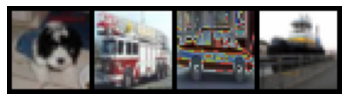

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from autoaugment import ImageNetPolicy

img_size = 32
train_transform = transforms.Compose([transforms.Resize((img_size, img_size)), ImageNetPolicy(), 
                                transforms.RandomHorizontalFlip(), transforms.ToTensor(),   
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor(),   
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

images, labels = next(iter(train_loader))
print(f"Input image is {images.size()[-2]}x{images.size()[-1]} size with {images.size()[-3]} channels")
print('Classes of data are: ',train_set.classes)

# show images
plt.axis("off")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:4], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [2]:
import torch.optim as optim
from EfficientNet_pytorch import EfficientNet, Trainer, AugTrainer

cuda = torch.cuda.is_available()
device = torch.device("cuda:2" if cuda else "cpu")

# Tested EfficientNet-B0
model = EfficientNet.from_name('efficientnet-b0', image_size=[img_size,img_size], num_classes=10, include_top=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Set to train : trained with CutMix & MixUp techniques
trainer = AugTrainer(model=model, optim=optimizer, scheduler=scheduler, train_loader=train_loader, 
                    val_loader=test_loader, test_loader=test_loader, device=device)

# Check number of parameters
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters : {pytorch_total_params}")

trainer.train(n_epoch=100, verbose_freq=50, aug_rate=0.5)
test_loss, test_acc = trainer.test_acc()
print(f'Test accuracy : {test_acc}%')

Number of model parameters : 4020358


  0%|          | 0/100 [00:00<?, ?it/s]

===> Epoch: 50 / Avg train loss: 1.156 / Train acc: 62.288% / Avg val loss: 0.709 / Val acc: 79.200%
===> Epoch: 100 / Avg train loss: 0.916 / Train acc: 70.381% / Avg val loss: 0.591 / Val acc: 82.390%
Test accuracy : 82.39%
